In [1]:
from pyspark.ml.torch.distributor import TorchDistributor 
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext('local')
spark = SparkSession(sc)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/05 15:23:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/12/05 15:23:47 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import random
import torch.nn as nn
import torch.optim as optim
import math
import os
from torch.utils.data import TensorDataset, random_split, DataLoader
import torch.nn.functional as F
from tqdm.notebook import trange, tqdm
from torchinfo import summary
from scipy.interpolate import interp1d, BSpline, splrep
from csaps import csaps
from skfda.representation.interpolation import SplineInterpolation
from scipy.interpolate import UnivariateSpline
from tslearn.metrics import SoftDTWLossPyTorch
from torch.utils.data import DataLoader, TensorDataset
from scipy.spatial.distance import cdist
import seaborn as sns
from scipy import stats
import time as time
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import warnings


warnings.filterwarnings("ignore", category=FutureWarning)
os.makedirs('./trained_networks/example', exist_ok=True) 

/Users/micheledisabato/Library/Python/3.9/lib/python/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [3]:
random_SEED = 42
np.random.seed(random_SEED)

df_raw_data = pd.read_csv('ECG5000/ecg.csv', header=None)
df_raw_data.columns = [f't{i+1}' for i in range(df_raw_data.shape[1] - 1)] + ['label'] # 4998x140 (+1 column for labels); 1: normal, 0: anomalous; 2079 normal
torch_data_normal = torch.tensor(df_raw_data[df_raw_data['label'] == True].values[:,:-1], dtype=torch.float32)
torch_data_anomalous = torch.tensor(df_raw_data[df_raw_data['label'] == False].values[:,:-1], dtype=torch.float32)
hold_out_idx = torch.tensor(random.sample(range(torch_data_normal.shape[0]), 500))
all_indices = torch.arange(torch_data_normal.shape[0])
remaining_indices = all_indices[~torch.isin(all_indices, hold_out_idx)]
hold_out_normal = torch_data_normal[hold_out_idx,:]
torch_data_normal = torch_data_normal[remaining_indices,:]
input_dim = torch_data_normal.shape[1]
encoding_dim = 10

# # Uncomment to increment the size of the training data to see if the notebook is scalable
# torch_data_normal = torch.concat((torch_data_normal,torch_data_normal,torch_data_normal,torch_data_normal,torch_data_normal,torch_data_normal,
#               torch_data_normal,torch_data_normal,torch_data_normal,torch_data_normal,torch_data_normal,
#               torch_data_normal,torch_data_normal,torch_data_normal,torch_data_normal,torch_data_normal))

print(f'Training data (normal): {torch_data_normal.shape[0]}')
print(f'Anomalous data: {torch_data_anomalous.shape[0]}')
print(f'Hold-out data (normal): {hold_out_normal.shape[0]}')
print(f'Total data: {hold_out_normal.shape[0]+torch_data_anomalous.shape[0]+torch_data_normal.shape[0]}')

train_datasets = []

num_splits = 7
split_sizes = [torch_data_normal.shape[0] // num_splits] * (num_splits - 1) + [torch_data_normal.shape[0] - (torch_data_normal.shape[0] // num_splits) * (num_splits - 1)]
train_datasets = torch.split(torch_data_normal, split_sizes)
for tt_idx, tt in enumerate(train_datasets):
    print(f"{tt.shape[0]} data in chunk number {tt_idx+1}")

Training data (normal): 2419
Anomalous data: 2079
Hold-out data (normal): 500
Total data: 4998
345 data in chunk number 1
345 data in chunk number 2
345 data in chunk number 3
345 data in chunk number 4
345 data in chunk number 5
345 data in chunk number 6
349 data in chunk number 7


In [4]:
class TimeSeriesAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(TimeSeriesAutoencoder, self).__init__()
        self.encode = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, encoding_dim),
        )
        
        self.decode = nn.Sequential(
            nn.Linear(encoding_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim)
        )

    def forward(self, x):
        encoded = self.encode(x)
        decoded = self.decode(encoded)
        return decoded
    

models = []
for i in range(num_splits):
    models.append(TimeSeriesAutoencoder(input_dim=input_dim, encoding_dim=encoding_dim))

In [5]:
def train_data_loader(split_index, datasets, batch_size):
    """This function creates the dataloader for each node.

    Parameters
    ----------
    split_index : (int)
        The number of the assigned node (0,1,...)
    datasets : (list)
        A list of datasets
    batch_size : (int)
        Size of the minibatch

    Returns
    -------
    A dataloader for the dataset at index split_index
    """

    train_dataset_split_index = TensorDataset(datasets[split_index])
    train_dataloader_split_index = DataLoader(train_dataset_split_index, batch_size=batch_size, shuffle=True)
    
    return(train_dataloader_split_index)

def training(models, train_datasets, criterion, num_epochs, batch_size, learning_rate, print_epoch):
    """This function creates the dataloader for each node.

    Parameters
    ----------
    models : [models]
        A list of models to be trained
    train_datasets : (list)
        A list of datasets to be used for training
    criterion : (function)
        Loss function
    num_epochs : (int)
        Number of epochs to be run
    batch_size : (int)
        Size of the minibatch
    learning_rate : (float)
        The learning rate for the optimizer
    print_epoch : (int)
        Determines if we print a loss and how often, set to 0 to omit print
    Returns
    -------
    A dataloader for the dataset at index split_index
    """

    
    local_rank = int(os.environ["LOCAL_RANK"])
    
    model = models[local_rank]
    
    dataloader = train_data_loader(local_rank, train_datasets, batch_size)
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(1,num_epochs+1):
        total_loss = 0
        for batch in dataloader:
            inputs = batch[0]
            outputs = model(inputs)
            loss = criterion(outputs, inputs)  
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        if print_epoch != 0:
            if epoch % print_epoch == 0:
                print(f"Model {local_rank} Epoch [{epoch}/{num_epochs}], Loss: {total_loss/len(dataloader):.6f}")
    
    torch.save(model.state_dict(), "./trained_networks/example/ensemble_" + str(local_rank) + ".pth")

    # # Attempted this, but it doesn't update the list accordingly
    # models[local_rank] = model
    return 

In [6]:
criterion = nn.MSELoss()

num_epochs = 100
batch_size = 32
learning_rate = 0.01

print_epoch = 0

start_time = time.time()

# run takes arguments: (<function to be run>, <arguments to be passed to function>)
TorchDistributor(num_processes=num_splits, local_mode=True, use_gpu=False).run(training, # function to run
                models, train_datasets, criterion, num_epochs, batch_size, learning_rate, print_epoch) # arguments to pass to function

print('It took ' , time.time()-start_time ,'s')

Started local training with 7 processes


[2024-12-05 15:23:51,364] torch.distributed.elastic.multiprocessing.redirects: [WARNING] NOTE: Redirects are currently not supported in Windows or MacOs.
master_addr is only used for static rdzv_backend and when rdzv_endpoint is not specified.
*****************************************
Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
*****************************************


Finished local training with 7 processes


It took  6.7167229652404785 s


In [7]:
# Done at post-training, inference/evaluation
# Loads the trained models from the folder trained_networks/example
models = []
for i in range(num_splits):
    models.append(TimeSeriesAutoencoder(input_dim=input_dim, encoding_dim=encoding_dim))
    models[i].load_state_dict(torch.load("./trained_networks/example/ensemble_" + str(i) + ".pth", weights_only=True))
    models[i].eval()

/Users/micheledisabato/Library/Python/3.9/lib/python/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [8]:
new_patients = torch.concat((hold_out_normal, torch_data_anomalous[torch.tensor(random.sample(range(torch_data_anomalous.shape[0]), 500)),:]))
true_labels = torch.concat((torch.ones(500), torch.zeros(500))).numpy()
mse_loss = nn.MSELoss()

reconstructed_new_patients_all = []
result_all = [] 
with torch.no_grad():
    for i in range(num_splits):
        i_model = models[i]
        i_model.eval()  
        reconstructed_new_patients_i = i_model(new_patients)
        reconstructed_new_patients_all.append(reconstructed_new_patients_i)
        new_patients_loss_i = []
        normal_loss_i = []
        for j in range(train_datasets[i].shape[0]):
            normal_loss_i.append(mse_loss(i_model(train_datasets[i][j,:]), train_datasets[i][j,:]).numpy())
        for j in range(new_patients.shape[0]):
            new_patients_loss_i.append(mse_loss(reconstructed_new_patients_i[j,:], new_patients[j,:]).numpy())
        normal_ecdf_i = stats.ecdf(normal_loss_i)
        result_i = normal_ecdf_i.cdf.evaluate(new_patients_loss_i)
        result_all.append(result_i)

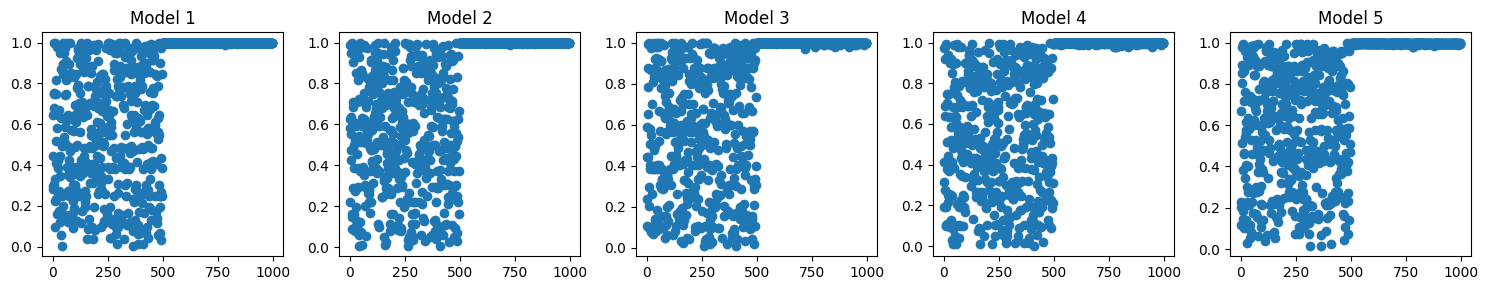

In [9]:
plt.figure(figsize=(15, 3))  # Adjust figure size for side-by-side plots
for i in range(5):
    plt.subplot(1, 5, i + 1)  # Create 5 side-by-side subplots
    plt.scatter(range(len(result_all[i])), result_all[i])
    plt.title(f"Model {i+1}")
plt.tight_layout()
plt.show()

In [10]:
alpha = 0.05

selected_indices_all = []
predicted_labels_all = []
cm_all = []
accuracy_all = []
precision_all = []
recall_all = []

for i in range(num_splits):
    result_i = result_all[i]
    selected_indices_i = np.where(result_i > 1-alpha)
    selected_indices_all.append(selected_indices_i)
    selected_values_i = result_i[selected_indices_i]

    predicted_labels_i = np.ones_like(true_labels)
    predicted_labels_i[selected_indices_i] = 0
    predicted_labels_all.append(predicted_labels_i)

    cm_i = confusion_matrix(true_labels, predicted_labels_i)
    cm_all.append(cm_i)

    print(f"Confusion Matrix from model {i+1}:")
    print(cm_i)

    accuracy_i = accuracy_score(true_labels, predicted_labels_i)
    accuracy_all.append(accuracy_i)
    precision_i = precision_score(true_labels, predicted_labels_i)
    precision_all.append(precision_i)
    recall_i = recall_score(true_labels, predicted_labels_i)
    recall_all.append(recall_i)

    print(f"Accuracy from model {i+1}: {accuracy_i}")
    print(f"Precision from model {i+1}: {precision_i}")
    print(f"Recall from model {i+1}: {recall_i}")

Confusion Matrix from model 1:
[[500   0]
 [ 51 449]]
Accuracy from model 1: 0.949
Precision from model 1: 1.0
Recall from model 1: 0.898
Confusion Matrix from model 2:
[[500   0]
 [ 34 466]]
Accuracy from model 2: 0.966
Precision from model 2: 1.0
Recall from model 2: 0.932
Confusion Matrix from model 3:
[[500   0]
 [ 51 449]]
Accuracy from model 3: 0.949
Precision from model 3: 1.0
Recall from model 3: 0.898
Confusion Matrix from model 4:
[[500   0]
 [ 33 467]]
Accuracy from model 4: 0.967
Precision from model 4: 1.0
Recall from model 4: 0.934
Confusion Matrix from model 5:
[[500   0]
 [ 43 457]]
Accuracy from model 5: 0.957
Precision from model 5: 1.0
Recall from model 5: 0.914
Confusion Matrix from model 6:
[[500   0]
 [ 62 438]]
Accuracy from model 6: 0.938
Precision from model 6: 1.0
Recall from model 6: 0.876
Confusion Matrix from model 7:
[[500   0]
 [ 55 445]]
Accuracy from model 7: 0.945
Precision from model 7: 1.0
Recall from model 7: 0.89
